In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import networkx as nx
from itertools import product
import os
from dtaidistance import dtw
import time
import torch

In [2]:
class TrafficGridAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.traffic_grid = None
        self.zero_indices = None
        self.zero_count = 0

    def load_data(self):
        with h5py.File(self.file_path, 'r') as f:
            for key in f.keys():  # 读取第一个 key 对应的数据
                data = np.array(f[key])  # 转换为 NumPy 数组
                self.traffic_grid = data[0]  # 取第一个通道
                break  # 只读取第一个 key

    def analyze_traffic(self, threshold=30):
        self.zero_indices = np.argwhere(self.traffic_grid < threshold)
        self.zero_count = self.zero_indices.shape[0]
        return self.zero_count, self.zero_indices.tolist()

    def visualize(self):
        # 绘制原始交通网格灰度图
        plt.figure(figsize=(10, 8))
        plt.imshow(self.traffic_grid, cmap='gray')
        plt.title('Original Traffic Network Visualization')
        plt.axis('off')
        plt.show()
        
        # 创建新灰度图矩阵，初始化为255
        visual_grid = np.full_like(self.traffic_grid, 255)
        
        # 将 zero_indices 对应的节点灰度值设置为0
        for row, col in self.zero_indices:
            visual_grid[row, col] = 0
        
        # 绘制提取的交通网络
        plt.figure(figsize=(10, 8))
        plt.imshow(visual_grid, cmap='gray')
        plt.title('Extracted Traffic Network Visualization')
        plt.axis('off')
        plt.show()


In [3]:
class TrafficDataAnalyzer:
    def __init__(self, march_half_filepath, march_filepath):
        self.march_half_filepath = march_half_filepath
        self.march_filepath = march_filepath
        self.Antwerp_traffic_last_half_march = None
        self.Antwerp_traffic_march = None
        self.average_traffic = None
        self.filtered_indices = None
        self.zero_indices = None

    def load_variable(self, filepath):
        """
        从文件中加载变量。
        """
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        return data

    def readdata(self, filepath):
        """
        读取数据文件并转换为 NumPy 数组。
        """
        data = self.load_variable(filepath)
        data = np.array(data)
        print(f"Loaded data shape: {data.shape}")
        return data

    def analyze_traffic(self, zero_indices):
        print('-----------------------------------------------------TrafficDataAnalyzer-----------------------------------------------------')
        # 读取数据
        self.Antwerp_traffic_last_half_march = self.readdata(self.march_half_filepath)
        self.Antwerp_traffic_march = self.readdata(self.march_filepath)
        
        self.zero_indices = zero_indices
        
        # 计算沿时间轴的平均交通流量
        self.average_traffic = np.mean(self.Antwerp_traffic_march, axis=0)
        
        # 排除 zero_indices 中的无连接节点
        for row, col in self.zero_indices:
            self.average_traffic[row, col] = np.nan

        # 计算 30% 和 95% 分位数
        valid_values = self.average_traffic[~np.isnan(self.average_traffic)]
        lower_bound = np.percentile(valid_values, 30)
        upper_bound = np.percentile(valid_values, 100)
        
        # 筛选出不在 30%-95% 范围内的节点
        valid_mask = ~np.isnan(self.average_traffic)
        outside_range_mask = (self.average_traffic < lower_bound) | (self.average_traffic > upper_bound)
        filtered_mask = valid_mask & outside_range_mask
        
        # 找到不在范围内的节点索引
        self.filtered_indices = np.argwhere(filtered_mask)
        filtered_count = self.filtered_indices.shape[0]
        
        # 创建 DataFrame 并打印结果
        filtered_df = pd.DataFrame(self.filtered_indices, columns=['Row', 'Column'])
        print(f"Filtered Traffic Indices (Outside {lower_bound}-{upper_bound} Range):")
        print(filtered_df)
        print(f"Total number of filtered traffic nodes: {filtered_count}")
        print(f"30% Percentile (Lower Bound): {lower_bound}")
        print(f"95% Percentile (Upper Bound): {upper_bound}")
        
        # 计算描述性统计信息
        for row, col in self.filtered_indices:
            self.average_traffic[row, col] = np.nan
        
        valid_mask_total = ~np.isnan(self.average_traffic)
        remaining_values = self.average_traffic[valid_mask_total].flatten()
        
        q1 = np.percentile(remaining_values, 25)
        median = np.percentile(remaining_values, 50)
        q3 = np.percentile(remaining_values, 75)
        iqr = q3 - q1
        mean = np.mean(remaining_values)
        min_val = np.min(remaining_values)
        max_val = np.max(remaining_values)
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        print(f"Minimum Value: {min_val}")
        print(f"Q1 (25th Percentile): {q1}")
        print(f"Median (50th Percentile): {median}")
        print(f"Q3 (75th Percentile): {q3}")
        print(f"Maximum Value: {max_val}")
        print(f"Mean: {mean}")
        print(f"Lower Bound (Whisker): {lower_bound}")
        print(f"Upper Bound (Whisker): {upper_bound}")

    def visualize(self):
        # 绘制箱型图
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=self.average_traffic[~np.isnan(self.average_traffic)].flatten())
        plt.title("Boxplot of Average Traffic Flow (Filtered)")
        plt.xlabel("Average Traffic Flow")
        plt.show()
        
        # 创建新的灰度图
        visual_grid = np.full_like(self.average_traffic, 255)
        for row, col in np.vstack((self.zero_indices, self.filtered_indices)):
            visual_grid[row, col] = 0
        
        plt.figure(figsize=(10, 8))
        plt.imshow(visual_grid, cmap='gray')
        plt.title('Filtered Traffic Network Visualization')
        plt.axis('off')
        plt.show()

        print('-----------------------------------------------------TrafficNetworkAnalyzer-----------------------------------------------------')


In [4]:
class TrafficNetworkAnalyzer:
    def __init__(self, average_traffic, zero_indices, filtered_indices):
        self.average_traffic = average_traffic
        self.zero_indices = zero_indices
        self.filtered_indices = filtered_indices
        self.G = nx.Graph()
        self.G_flat = nx.Graph()
        self.visual_grid = None
        self.filtered_visual_grid = None
        self.rows, self.cols = average_traffic.shape

    def construct_graph(self):
        # 创建灰度图矩阵，初始化为255
        self.visual_grid = np.full_like(self.average_traffic, 255)
        
        # 将 zero_indices 和 filtered_indices 对应的节点灰度值设为0
        for row, col in self.zero_indices:
            self.visual_grid[row, col] = 0
        for row, col in self.filtered_indices:
            self.visual_grid[row, col] = 0
        
        # 添加灰度值为255的节点
        for r, c in product(range(self.rows), range(self.cols)):
            if self.visual_grid[r, c] == 255:
                self.G.add_node((r, c))

        # 添加边（8邻域连接）
        for r, c in self.G.nodes():
            neighbors = [
                (r-1, c), (r+1, c), (r, c-1), (r, c+1),
                (r-1, c-1), (r-1, c+1), (r+1, c-1), (r+1, c+1)
            ]
            for nr, nc in neighbors:
                if 0 <= nr < self.rows and 0 <= nc < self.cols and self.visual_grid[nr, nc] == 255:
                    self.G.add_edge((r, c), (nr, nc))

        # 找到孤立节点并移除
        isolated_nodes = list(nx.isolates(self.G))
        self.G.remove_nodes_from(isolated_nodes)

        print(f"Number of isolated nodes：{len(isolated_nodes)}")
        print(f"Number of nodes in the one-step graph: {len(self.G.nodes())}, number of edges: {len(self.G.edges())}")

    def compute_shortest_paths(self):
        # 计算所有节点对的最短路径长度（最多5阶）
        path_lengths = {node: nx.single_source_shortest_path_length(self.G, node, cutoff=5) for node in self.G.nodes()}
        
        # 5阶内的连接性作为新边添加到图中
        for source, targets in path_lengths.items():
            for target, length in targets.items():
                if length > 0 and length <= 5:
                    self.G.add_edge(source, target)

        # 生成DataFrame
        data = [[node, neighbor, length] for node, neighbors in path_lengths.items() for neighbor, length in neighbors.items()]
        df_paths = pd.DataFrame(data, columns=['Source Node', 'Target Node', 'Path Length'])

        print(f"Number of nodes in the five-step graph: {len(self.G.nodes())}, number of edges: {len(self.G.edges())}")

    def filter_connected_nodes(self):
        # 重新构造 visual_grid，只保留连通的节点
        self.filtered_visual_grid = np.full_like(self.visual_grid, 0)  # 先设为黑色
        for r, c in self.G.nodes():
            self.filtered_visual_grid[r, c] = 255  # 仅保留非孤立节点

        # 绘制最终的灰度图
        plt.figure(figsize=(10, 8))
        plt.imshow(self.filtered_visual_grid, cmap='gray')
        plt.title('Filtered Traffic Network Without Isolated Nodes')
        plt.axis('off')
        plt.show()

    def flatten_graph(self):
        def to_flat_index(r, c, cols):
            return r * cols + c

        # 创建新的扁平化后的图
        self.G_flat = nx.Graph()
        
        # 添加扁平化后的节点
        for node in self.G.nodes():
            flat_index = to_flat_index(node[0], node[1], self.cols)
            self.G_flat.add_node(flat_index)
        
        # 添加扁平化后的边
        for u, v in self.G.edges():
            u_flat = to_flat_index(u[0], u[1], self.cols)
            v_flat = to_flat_index(v[0], v[1], self.cols)
            self.G_flat.add_edge(u_flat, v_flat)

        # ✅ 添加自环（每个节点连接到自己）
        for node in self.G_flat.nodes():
            self.G_flat.add_edge(node, node)
        
        print(f"Number of nodes after flattened: {len(self.G_flat.nodes())}")
        print(f"Number of edges after flattened: {len(self.G_flat.edges())}")
        print('-----------------------------------------------------TrafficDataProcessor-----------------------------------------------------')
        
        return self.G_flat  # 返回完整的 networkx 图


In [5]:
class TrafficDataProcessor:
    def __init__(self, data, G_flat):
        self.data = data
        self.G_flat = G_flat
        self.valid_nodes = sorted(list(G_flat.nodes()))  # 经过扁平化的有效节点
        self.filtered_data = None

    def filter_and_flatten(self):
        """
        过滤数据，仅保留 G_flat 中的节点，转换形状 (time_steps, num_valid_nodes)。
        """
        time_steps = self.data.shape[0]

        # 将数据展平成 (time_steps, num_rows*num_cols)
        data_flat = self.data.reshape(time_steps, -1)
        
        # 仅保留 G_flat 中的有效节点
        self.filtered_data = data_flat[:, self.valid_nodes]
        
        print(f"Shape after filtered and flattened: {self.filtered_data.shape} (time_steps, num_valid_nodes)")
        return self.filtered_data, self.valid_nodes

    def save_sliding_window_with_dtw(self, save_dir, history_size=6, forecast_size=6):
        """
        生成滑动窗口数据，并计算DTW，存入G_flat的边权重中，并记录每个窗口的计算时间。
        """
        time_steps, num_valid_nodes = self.filtered_data.shape
        num_samples = time_steps - history_size - forecast_size + 1

        os.makedirs(save_dir, exist_ok=True)
        
        X_all = []
        Y_all = []
        dtw_graphs = []
        # time_records = []

        for i in range(num_samples):
            start_time = time.time()  # 记录起始时间

            # 取 [i, i+history_size) 这段做X
            hist_data = self.filtered_data[i : i + history_size, :]
            # 取 [i+history_size, i+history_size+forecast_size) 这段做Y
            fut_data = self.filtered_data[i + history_size : i + history_size + forecast_size, :]

            # 复制当前 G_flat 以存储DTW权重
            G_dtw = self.G_flat.copy()

            # 遍历图的所有边，计算DTW
            for u, v in G_dtw.edges():
                # print(f"Sequence 1: {hist_data[:, self.valid_nodes.index(u)].astype(np.float32)}")
                # print(f"Sequence 2: {hist_data[:, self.valid_nodes.index(v)].astype(np.float32)}")
                dtw_distance = dtw.distance(hist_data[:, self.valid_nodes.index(u)].astype(np.float32),
                                            hist_data[:, self.valid_nodes.index(v)].astype(np.float32))
                G_dtw[u][v]['weight'] = dtw_distance

            X_all.append(hist_data)
            Y_all.append(fut_data)
            dtw_graphs.append(G_dtw)

            end_time = time.time()  # 记录结束时间
            elapsed_time = end_time - start_time
            # time_records.append(elapsed_time)
            print(f"Sliding window {i+1}/{num_samples} is generated，cost: {elapsed_time:.4f} seconds")

        # 转换为 NumPy 数组
        X_all = np.array(X_all, dtype=np.float32)
        print(f"shape of X {X_all.shape}")
        Y_all = np.array(Y_all, dtype=np.float32)
        print(f"shape of Y {Y_all.shape}")
        
        # 保存数据
        np.save(os.path.join(save_dir, "X.npy"), X_all)
        np.save(os.path.join(save_dir, "Y.npy"), Y_all)
        # np.save(os.path.join(save_dir, "time_records.npy"), np.array(time_records))
        
        # 保存 DTW 加权图对象（使用 pickle）
        with open(os.path.join(save_dir, "DTW_graphs.pkl"), 'wb') as f:
            pickle.dump(dtw_graphs, f)
        
        print(f"Data has been saved to '{save_dir}', shape: X {X_all.shape}, Y {Y_all.shape}.")
        print(f"Saved {len(dtw_graphs)} graphs with DTW weights.")
        # print(f"平均每个滑动窗口计算耗时: {np.mean(time_records):.4f} 秒")
        print('----------------------------------------------------------------------------------------------------------')

        return dtw_graphs

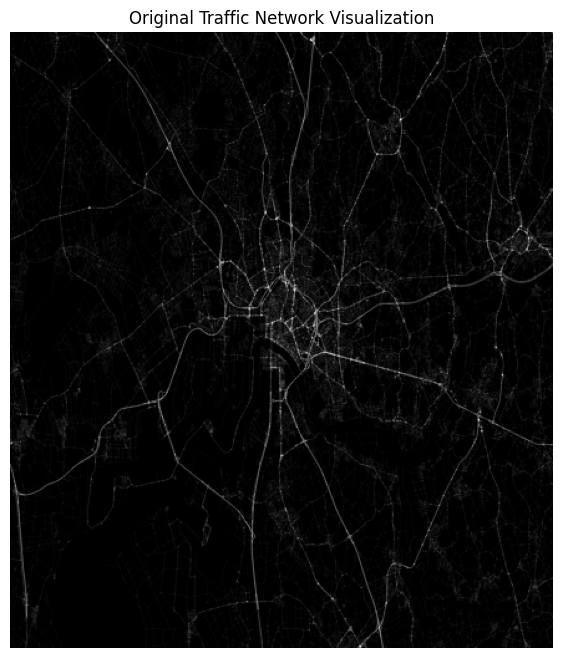

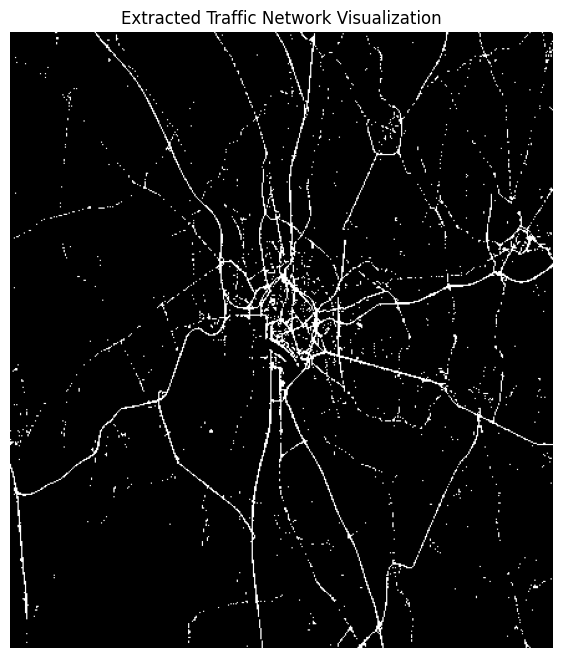

Zero Count: 207289
-----------------------------------------------------TrafficDataAnalyzer-----------------------------------------------------
Loaded data shape: (720, 495, 436)
Loaded data shape: (180, 495, 436)
Filtered Traffic Indices (Outside 84.97777777777777-2873.311111111111 Range):
      Row  Column
0       0      36
1       0      37
2       0     234
3       0     350
4       0     351
...   ...     ...
2554  493     282
2555  493     285
2556  494     282
2557  494     414
2558  494     417

[2559 rows x 2 columns]
Total number of filtered traffic nodes: 2559
30% Percentile (Lower Bound): 84.97777777777777
95% Percentile (Upper Bound): 2873.311111111111
Minimum Value: 84.97777777777777
Q1 (25th Percentile): 145.46527777777777
Median (50th Percentile): 243.44166666666666
Q3 (75th Percentile): 419.5208333333333
Maximum Value: 2873.311111111111
Mean: 347.3069286299025
Lower Bound (Whisker): -265.61805555555554
Upper Bound (Whisker): 830.6041666666666


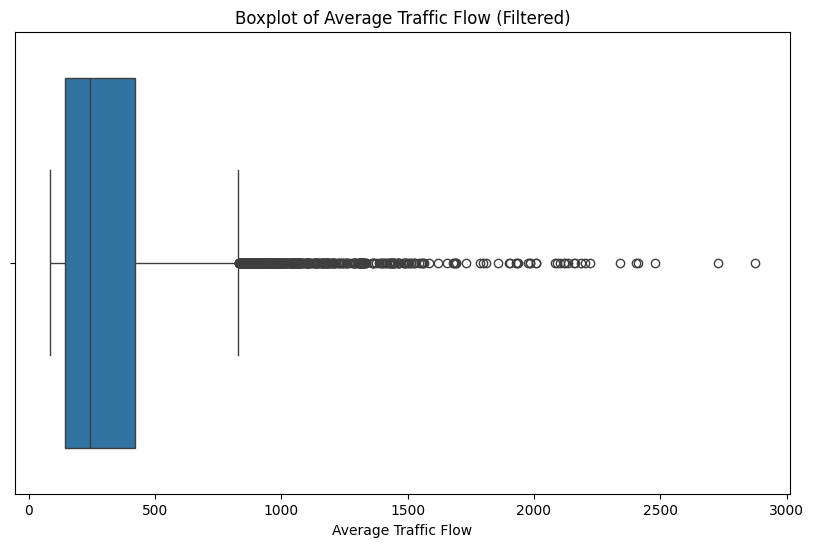

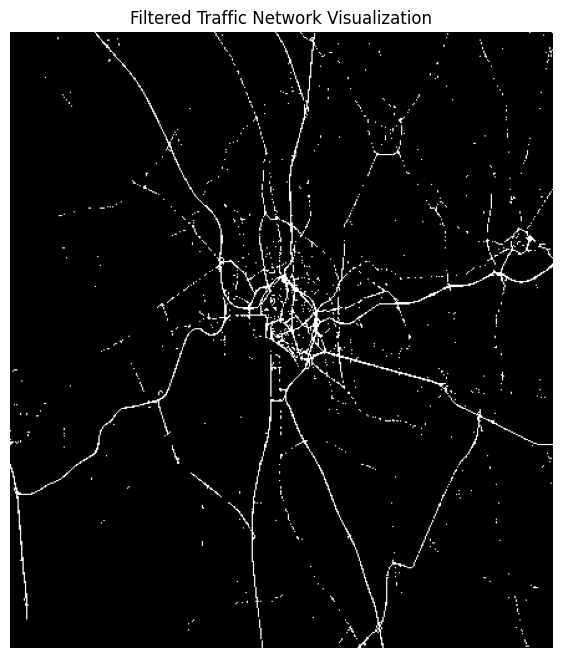

-----------------------------------------------------TrafficNetworkAnalyzer-----------------------------------------------------
Number of isolated nodes：460
Number of nodes in the one-step graph: 5512, number of edges: 8429
Number of nodes in the five-step graph: 5512, number of edges: 43158


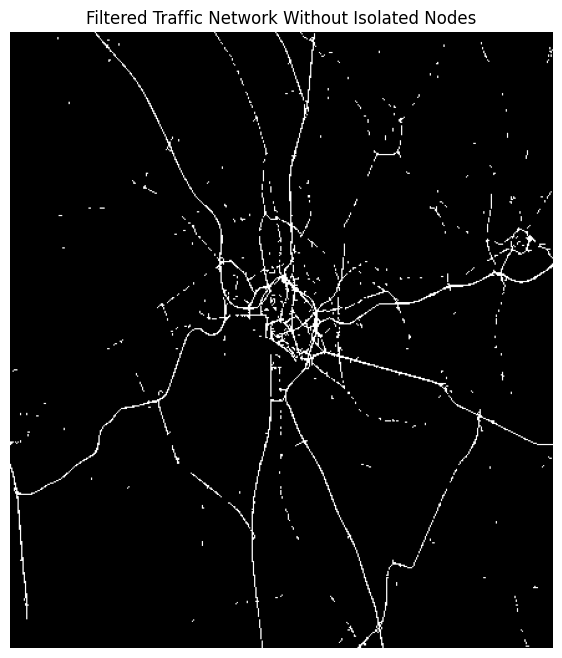

Number of nodes after flattened: 5512
Number of edges after flattened: 48670
-----------------------------------------------------TrafficDataProcessor-----------------------------------------------------
Shape after filtered and flattened: (720, 5512) (time_steps, num_valid_nodes)
Sliding window 1/709 is generated，cost: 11.1712 seconds
Sliding window 2/709 is generated，cost: 11.3392 seconds
Sliding window 3/709 is generated，cost: 11.4562 seconds
Sliding window 4/709 is generated，cost: 11.2605 seconds
Sliding window 5/709 is generated，cost: 11.4348 seconds
Sliding window 6/709 is generated，cost: 10.6390 seconds
Sliding window 7/709 is generated，cost: 11.0558 seconds
Sliding window 8/709 is generated，cost: 10.6628 seconds
Sliding window 9/709 is generated，cost: 11.1583 seconds
Sliding window 10/709 is generated，cost: 10.5892 seconds
Sliding window 11/709 is generated，cost: 10.7738 seconds
Sliding window 12/709 is generated，cost: 10.7637 seconds
Sliding window 13/709 is generated，cost: 10

In [6]:
# 使用示例
if __name__ == "__main__":
    
    file_path = "E:\\Techniche University of Munich\\master thesis\\ANTWERP\\ANTWERP\\ANTWERP_static.h5"
    analyzer = TrafficGridAnalyzer(file_path)
    analyzer.load_data()
    zero_count, zero_indices = analyzer.analyze_traffic()
    analyzer.visualize()
    print(f"Zero Count: {zero_count}")
    # print(f"Zero Count: {zero_indices}")

    march_half_filepath = r"E:\Techniche University of Munich\master thesis\ANTWERP\preprocessed_data\sliding_window\7days\30min\Antwerp_march_last_half_month_samples_30min_timesteps.txt"
    march_filepath = r"E:\Techniche University of Munich\master thesis\ANTWERP\preprocessed_data\sliding_window\2019 samples for gray map\Antwerp_2019_samples_30min_timesteps.txt"
    
    analyzer = TrafficDataAnalyzer(march_half_filepath, march_filepath)
    analyzer.analyze_traffic(zero_indices)
    analyzer.visualize()
    
    
    Antwerp_traffic_last_half_march = analyzer.Antwerp_traffic_last_half_march
    Antwerp_traffic_march = analyzer.Antwerp_traffic_march
    average_traffic = analyzer.average_traffic
    filtered_indices = analyzer.filtered_indices

    analyzer = TrafficNetworkAnalyzer(average_traffic, zero_indices, filtered_indices)
    analyzer.construct_graph()
    analyzer.compute_shortest_paths()
    analyzer.filter_connected_nodes()
    G_flat = analyzer.flatten_graph()

    save_dir = r"E:\Techniche University of Munich\master thesis\ANTWERP\preprocessed_data\sliding_window\15days\30min"
    history_size = 6
    forecast_size = 6
    
    processor = TrafficDataProcessor(Antwerp_traffic_last_half_march, G_flat)
    filtered_data, valid_nodes = processor.filter_and_flatten()
    dtw_graphs = processor.save_sliding_window_with_dtw(save_dir, history_size=history_size, forecast_size=forecast_size)

In [45]:
G_dtw = dtw_graphs[0]  # 取出第一个滑动窗口的 DTW 图
print("Graph 1:")
node = 68  # 假设你想找节点 68 的边权重

# 遍历该节点的所有邻居，打印边的 DTW 权重
for neighbor, data in G_dtw[node].items():
    print(f"Edge {node} - {neighbor}, DTW Weight: {data['weight']}")

Graph 1:
Edge 68 - 505, DTW Weight: 4.123105625617661
Edge 68 - 941, DTW Weight: 3.3166247903554
Edge 68 - 942, DTW Weight: 4.242640687119285
Edge 68 - 1378, DTW Weight: 3.7416573867739413
Edge 68 - 1379, DTW Weight: 3.872983346207417
Edge 68 - 1815, DTW Weight: 3.3166247903554
Edge 68 - 2252, DTW Weight: 2.6457513110645907
Edge 68 - 68, DTW Weight: 0.0


In [47]:
edge_index = torch.tensor(list(G_dtw.edges()), dtype=torch.long).t().contiguous()
edge_weight = torch.tensor([G_dtw[u][v]['weight'] for u, v in G_dtw.edges()], dtype=torch.float)

In [49]:
print("edge_index [:, :20]:", edge_index[:, :20])
print("edge_weight [:, :20]:", edge_weight[:20])

edge_index [:, :20]: tensor([[  68,   68,   68,   68,   68,   68,   68,   68,  164,  164,  164,  164,
          164,  164,  213,  213,  213,  213,  213,  213],
        [ 505,  941,  942, 1378, 1379, 1815, 2252,   68,  601, 1037, 1474, 1911,
         2347,  164,  650, 1086, 1087, 1523, 1960, 2396]])
edge_weight [:, :20]: tensor([4.1231, 3.3166, 4.2426, 3.7417, 3.8730, 3.3166, 2.6458, 0.0000, 1.7321,
        2.2361, 2.0000, 2.0000, 2.6458, 0.0000, 3.1623, 5.4772, 3.7417, 4.7958,
        3.4641, 2.6458])


In [51]:
print("edge_index [:, -20:]:", edge_index[:, -20:])  # 取最后 20 条边
print("edge_weight [:, -20:]:", edge_weight[-20:])  # 取最后 20 个权重

edge_index [:, -20:]: tensor([[215229, 215229, 215229, 215229, 215247, 215247, 215362, 215362, 215362,
         215363, 215363, 215364, 215586, 215663, 215663, 215663, 215664, 215664,
         215665, 215683],
        [215665, 215664, 215663, 215229, 215683, 215247, 215363, 215364, 215362,
         215364, 215363, 215364, 215586, 215664, 215665, 215663, 215665, 215664,
         215665, 215683]])
edge_weight [:, -20:]: tensor([7.0711, 7.1414, 7.0711, 0.0000, 4.3589, 0.0000, 2.0000, 0.0000, 0.0000,
        1.7321, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000])
